In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
#from wordcloud import WordCloud
import datetime as datetime
import os

In [2]:
from scipy.stats import chi2

In [3]:
%matplotlib inline
sns.set_style("whitegrid")

In [4]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM, select_order
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import ccf

In [ ]:
tweets = pd.read_csv("../data/cascade_analysis_data/anonymized_tweet_for_info_flow.csv")

## Bot-human conversation flow calculation

In [32]:
from scipy.stats import ttest_ind

In [33]:
import statistics
def generate_info_flow(threshold, bot_col, df = tweet, topic = None):
    #print(df.shape[0])
    df['is_bot'] = [1 if i>threshold else 0 for i in df[bot_col]]
    users['is_bot'] = [1 if i>threshold else 0 for i in users[bot_col]]
    print(statistics.median(users[users.is_bot == 1][bot_col]))
    df['from_is_bot'] = df.is_bot
    #print(df.columns)
    df = df.merge(tweet[['id_x','is_bot', 'topic']], how = 'left', 
                    left_on = 'referenced_tweets_0_id', right_on = 'id_x', suffixes = ("", "_rt"), copy = False)
    df = df.merge(users[['id','is_bot']], how = 'left', 
                    left_on = 'in_reply_to_user_id', right_on = 'id', suffixes = ("", "_reply"), copy = False)
    df['to_is_bot'] = np.where(np.isnan(df.is_bot_rt), df.is_bot_reply, df.is_bot_rt)
    df['to_is_bot'] = np.where(np.isnan(df.to_is_bot), df.from_is_bot, df.to_is_bot)
    
    if topic is not None:
        df = df[(df.topic==topic) | (df.topic_rt==topic)]
    df_comm = df
    comm_flow = {}
    print(len(set(df[df.is_bot==0]['author_id'])))
    print(len(set(df[df.is_bot==1]['author_id'])))    

    comm_flow['human_self'] = df_comm[(df_comm.from_is_bot == 0) & (df_comm.to_is_bot == 0)].shape[0]
    comm_flow['bot_self'] = df_comm[(df_comm.from_is_bot == 1) & (df_comm.to_is_bot == 1)].shape[0]
    comm_flow['human_rt_bot'] = df_comm[(df_comm.from_is_bot == 0) & (df_comm.to_is_bot == 1)].shape[0]
    comm_flow['bot_rt_human'] = df_comm[(df_comm.from_is_bot == 1) & (df_comm.to_is_bot == 0)].shape[0]
    comm_pct = {k:(v*100/df_comm.shape[0]) for k,v in comm_flow.items()}
    comm_pct['n_human'] = df_comm[(df_comm.is_bot == 0)].shape[0]
    comm_pct['n_bot'] = df_comm[(df_comm.is_bot == 1)].shape[0]
    
    comm_pct['human_self_senti'] = df_comm[(df_comm.from_is_bot == 0) & (df_comm.to_is_bot == 0)].sentiment.mean()
    comm_pct['bot_self_senti'] = df_comm[(df_comm.from_is_bot == 1) & (df_comm.to_is_bot == 1)].sentiment.mean()
    comm_pct['human_rt_bot_senti'] = df_comm[(df_comm.from_is_bot == 0) & (df_comm.to_is_bot == 1)].sentiment.mean()
    comm_pct['bot_rt_human_senti'] = df_comm[(df_comm.from_is_bot == 1) & (df_comm.to_is_bot == 0)].sentiment.mean()
    
    if threshold == 0.65:
        result_means = df.groupby(['from_is_bot', 'to_is_bot'])['sentiment'].agg([np.mean, np.std]).fillna(0).reset_index()
        print(result_means)
        t_stat, p_value = ttest_ind(df[(df['from_is_bot'] == 1) & (df['to_is_bot'] == 0)]['sentiment'], df[(df['from_is_bot'] != 1) | (df['to_is_bot'] != 0)]['sentiment'], equal_var=False)
        print(t_stat)
        print(p_value)
    return comm_flow, comm_pct,df_comm
    

### Info flow - by thresholds

In [ ]:
flows = []
pct = []
for threshold in [0.5, 0.55, 0.6, 0.65, 0.7, 0.75,0.8]:
    comm_flow, comm_pct, df_comm = generate_info_flow(threshold, 'is_bot_botometer_prob')
    flows.append(comm_flow)
    pct.append(comm_pct)

In [ ]:
comm_pct_df = pd.DataFrame.from_records(pct)
comm_flow_df = pd.DataFrame.from_records(flows)

In [ ]:
comm_pct_df['Threshold'] = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75,0.8]

In [ ]:
comm_pct_df.applymap(lambda x: round(x,2))

### Info flow - topics OVERALL period

In [ ]:
#comm_pct_df[['human_self','bot_self','human_rt_bot','bot_rt_human']] = comm_pct_df[['human_self','bot_self','human_rt_bot','bot_rt_human']].round(decimals = 2)
#comm_pct_df['Topics'] = list(range(1,8))
#comm_pct_df.columns = ["Human RT bot (%)", "Human RT human (%)", "Bot RT bot (%)", "Bot RT human (%)", "N tweets - human",
                     # "N tweets - bots", "Topics"]
#comm_pct_df = comm_pct_df[['Topics', "Human RT bot (%)", "Human RT human (%)", "Bot RT bot (%)", "Bot RT human (%)", "N tweets - human",
                 #     "N tweets - bots"]]

In [ ]:
from collections import Counter
Counter(tweet.topic)

In [ ]:
## Information flow for topics - overall. Index are topics.

topic_flow = []
topic_pct = []
for topic in range(8):
    comm_flow, comm_pct, df_ = generate_info_flow(0.65, 'is_bot_botometer_prob', tweet, topic)
    topic_flow.append(comm_flow)
    topic_pct.append(comm_pct)

In [ ]:
pd.DataFrame.from_records(topic_pct).applymap(lambda x: round(x,2))

In [ ]:
import scipy.stats as stats
from scipy.stats import chi2_contingency

In [ ]:
stats.chi2_contingency([[0.17, 0.40],[0.11, 0.25]])	

In [ ]:
stats.chi2_contingency([[16.18,29.28],[47.90,6.64]])	

### Info flow -topics DURING CASCADES

In [ ]:
cascades = {
           0: ["2019-11-23 18:00:00", "2019-11-24 08:00:00"],
           4: ["2019-11-23 17:00:00", "2019-11-24 06:00:00"],
           5: ["2019-11-29 18:00:00", "2019-11-30 04:00:00"],
           6:["2019-11-23 18:00:00", "2019-11-24 02:00:00"]
}

In [ ]:
topic_flow = []
topic_pct = []
for topic in cascades.keys():
    date_start = cascades[topic][0]
    date_end = cascades[topic][1]
    temp_df = tweet[(tweet.created_at_dt >= date_start) & (tweet.created_at_dt <= date_end)]
    comm_flow, comm_pct, temp_df = generate_info_flow(0.65, 'is_bot_botometer_prob', temp_df, topic)
    topic_flow.append(comm_flow)
    topic_pct.append(comm_pct)

In [ ]:
cascade_flow = pd.DataFrame.from_records(topic_pct).applymap(lambda x: round(x,2))
cascade_flow['Topics'] = [1,5,6,7]
cascade_flow

## Functions for creating time series

In [28]:
def create_time_series(df1, df2):
    f = plt.figure(figsize = (8, 4), dpi = 300)
    ax = f.add_subplot(111)
    ax.plot(df1.created_at_dt, df1.id_x, label = "Bots")
    ax.plot(df2.created_at_dt, df2.id_x, label = "Humans")
    ax.set_xlabel("Time")
    ax.set_ylabel("Number of tweets")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %H:%M'))
    plt.legend()
    plt.show()
    return

In [29]:
import matplotlib.dates as mdates
#create_time_series(by_min_bot, by_min_user)

In [30]:
#Granger causality
from statsmodels.tsa.stattools import adfuller,kpss,grangercausalitytests


In [31]:
def stationary_test(df, col):
    print("AdFuller:")
    print(adfuller(df[col], regression = 'ct'))
    print("kpss:")
    print(kpss(df[col], regression = 'ct'))
    return


In [32]:
#Remove trends
def get_diff(df):
    df_temp = df
    df_temp['diff_num'] = df_temp.id_x - df_temp.id_x.shift(1)
    df_temp = df_temp.dropna()
    return df_temp

## Calculate bot-human effect on cascade peaks

### Functions

In [33]:
threshold = 0.65
tweet['is_bot_botometer_binary'] = [1 if i>threshold else 0 if i<=0.5 else None for i in tweet.is_bot_botometer_prob] 

In [34]:
# 

def get_time_series(topic_num, date_start, date_end, is_bot, freq):
    temp_df = tweet.copy()
    temp_df.index = temp_df.created_at_dt
    if date_start is not None and date_end is not None:
        temp_df = temp_df[(temp_df.index >= date_start) & (temp_df.index <= date_end)]
    temp_df = temp_df[temp_df.topic == topic_num]
    if is_bot is not None:
        df = temp_df[temp_df.is_bot_botometer_binary == is_bot].groupby(pd.Grouper(freq = freq)).aggregate('count')[['id_x']].reset_index()
    else:
        df = temp_df.groupby(pd.Grouper(freq = freq)).aggregate('count')[['id_x']].reset_index()
    return df



def get_time_series_senti(topic_num, date_start, date_end, is_bot, freq):
    temp_df = tweet.copy()
    temp_df.index = temp_df.created_at_dt
    if date_start is not None and date_end is not None:
        temp_df = temp_df[(temp_df.index >= date_start) & (temp_df.index <= date_end)]
    temp_df = temp_df[temp_df.topic == topic_num]
    df = temp_df[temp_df.is_bot_botometer_binary == is_bot].groupby(pd.Grouper(freq = freq))['sentiment'].mean().reset_index()
    return df

def get_time_series_abs_senti(topic_num, date_start, date_end, is_bot, freq):
    temp_df = tweet.copy()
    temp_df.index = temp_df.created_at_dt
    if date_start is not None and date_end is not None:
        temp_df = temp_df[(temp_df.index >= date_start) & (temp_df.index <= date_end)]
    temp_df = temp_df[temp_df.topic == topic_num]
    df = temp_df[temp_df.is_bot_botometer_binary == is_bot].groupby(pd.Grouper(freq = freq))['abs_senti'].mean().reset_index()
    return df

def get_media_ctrl(date_start, date_end, df=media_ctrl):
    temp_df = df.copy()
    
    temp_df['created_at'] = pd.to_datetime(temp_df['created_at'])
    
    # Filter the DataFrame based on the date range
    if date_start is not None and date_end is not None:
        temp_df = temp_df[(temp_df['created_at'] >= date_start) & (temp_df['created_at'] <= date_end)]
        
    # Rename the columns as required
    temp_df.columns = ['created_at_dt', "media_human", "media_bot"]
    
    return temp_df

In [35]:
from scipy import stats

def wald_test_coef(coef_A_to_B,coef_B_to_A, se_A_to_B,se_B_to_A, df=1):
    # Calculate the difference in coefficients
    #coef_diff = coef_A_to_B - coef_B_to_A
    wald_statistic = ((coef_A_to_B - coef_B_to_A) ** 2) / (se_A_to_B ** 2 + se_B_to_A ** 2)


    # Degrees of freedom (assuming large sample, you can approximate with large number)
    p_value = 1 - chi2.cdf(wald_statistic, df)
    # One-sided p-value for the F-test (t-test)

    print(f"Wald Statistic: {wald_statistic}, P-value: {p_value}")
    return

In [36]:
from scipy import stats

def normalised_F_test_coef(coef_A_to_B,coef_B_to_A, se_A_to_B,se_B_to_A, len1, len2):
    
    # Normalize the coefficients
    normalized_coef_A_to_B = coef_A_to_B / se_A_to_B
    normalized_coef_B_to_A = coef_B_to_A / se_B_to_A

    coef_diff = coef_A_to_B - coef_B_to_A

    se_diff = (se_A_to_B**2 + se_B_to_A**2)**0.5

    t_stat = coef_diff / se_diff
    

    # Degrees of freedom (assuming large sample, you can approximate with large number)
    normalized_coef_diff = normalized_coef_A_to_B - normalized_coef_B_to_A

    # Estimate the standard error for the normalized coefficients
    se_normalized_coef1 = std_coef1[0] / np.sqrt(len(data1))
    se_normalized_coef2 = std_coef2[0] / np.sqrt(len(data2))

    # Standard error of the difference
    se_diff_normalized = np.sqrt(se_normalized_coef1**2 + se_normalized_coef2**2)

    # t-statistic
    t_stat_normalized = normalized_coef_diff / se_diff_normalized

    # Degrees of freedom (assuming large sample, you can approximate with large number)
    df = len1 + len2 -2 

    # One-sided p-value for the F-test (t-test)
    p_value_normalized = stats.t.sf(t_stat_normalized, df)

    print(f"T-statistic (normalized): {t_stat_normalized}, P-value (normalized): {p_value_normalized}")

    return

In [44]:
set(tweet.topic)

{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0}

In [31]:
from statsmodels.tsa.api import VAR

In [32]:
media_ctrl.created_at

0       2019-11-15 02:00:00+00:00
1       2019-11-15 02:05:00+00:00
2       2019-11-15 02:10:00+00:00
3       2019-11-15 02:15:00+00:00
4       2019-11-15 02:20:00+00:00
                  ...            
8027    2019-12-12 22:55:00+00:00
8028    2019-12-12 23:00:00+00:00
8029    2019-12-12 23:05:00+00:00
8030    2019-12-12 23:10:00+00:00
8031    2019-12-12 23:15:00+00:00
Name: created_at, Length: 8032, dtype: object

### Tweet freq

#### Topic 5

In [45]:
df5_bot = get_time_series(5, "2019-11-29 17:00:00", "2019-11-30 04:00:00", 1, '5Min')
df5_user = get_time_series(5, "2019-11-29 17:00:00", "2019-11-30 04:00:00", 0, '5Min')

In [46]:
media_ctrl_t5 = get_media_ctrl("2019-11-29 17:00:00", "2019-11-30 04:00:00")

<Axes: >

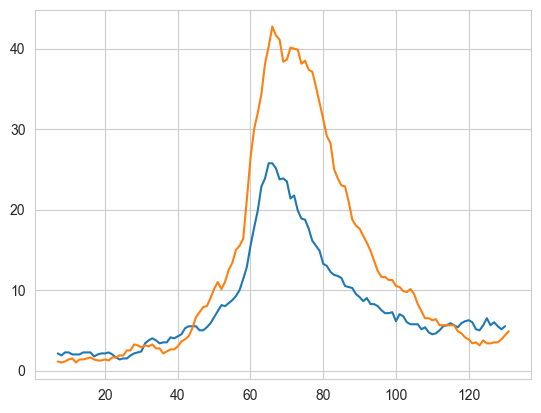

In [47]:
df5_bot.id_x.rolling(8).mean().plot()
df5_user.id_x.rolling(8).mean().plot()

In [49]:
df5bot_diff = get_diff(df5_bot)
df5user_diff = get_diff(df5_user)

In [50]:
df5_total = df5bot_diff.merge(df5user_diff, on = "created_at_dt", how = "outer", suffixes=('_bot', '_human'))
df5_total['bot_pct'] = df5_total.id_x_bot/(df5_total.id_x_bot+df5_total.id_x_human)
df5_total.fillna(0, inplace = True)
df5_total = df5_total.merge(media_ctrl_t5, left_on = "created_at_dt", right_on = "created_at_dt", how = "left")

In [56]:
jres = coint_johansen(df5_total[['id_x_bot', "id_x_human"]], det_order=0,k_ar_diff=1)

In [57]:
print(jres.eig)
print(jres.cvt)

[0.32997538 0.01747197]
[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]


##### VAR

In [51]:
m_t5= VAR(df5_total[['diff_num_bot', 'diff_num_human', "media_bot", "media_human"]])
results = m_t5.fit(maxlags=25, ic='aic') 
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 20, Jun, 2024
Time:                     23:53:23
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    1.35334
Nobs:                     106.000    HQIC:                  -4.68353
Log likelihood:           268.658    FPE:                   0.217100
AIC:                     -8.79788    Det(Omega_mle):       0.0149280
--------------------------------------------------------------------
Results for equation diff_num_bot
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                     -1.231451         2.823402           -0.436           0.663
L1.diff_num_bot           -0.915176         0.334052           -2.740           0.006
L1.diff_num_human          0.1996

##### VACE

In [52]:
lag_order = select_order(df5_total[['id_x_bot', 'id_x_human', "media_human", "media_bot"]], maxlags=25, deterministic="ci")

# Fit the VECM model
vecm_t5 = VECM(df5_total[['id_x_bot', 'id_x_human', "media_human", "media_bot"]], k_ar_diff=lag_order.aic,coint_rank=1)
vecm_results = vecm_t5.fit()
print(vecm_results.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation id_x_bot
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
L1.id_x_bot         0.1479      0.045      3.256      0.001       0.059       0.237
L1.id_x_human      -0.2064      0.029     -7.173      0.000      -0.263      -0.150
L1.media_human     54.8337      7.094      7.730      0.000      40.930      68.738
L1.media_bot      -46.1808      6.273     -7.362      0.000     -58.476     -33.886
L2.id_x_bot         0.4191      0.050      8.402      0.000       0.321       0.517
L2.id_x_human      -0.3575      0.039     -9.100      0.000      -0.435      -0.281
L2.media_human     59.2766      6.847      8.658      0.000      45.857      72.696
L2.media_bot      -42.1461      5.920     -7.119      0.000     -53.749     -30.543
L3.id_x_bot         0.5771      0.069      8.369      0.000       0.442 

/home/lindali/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/vector_ar/vecm.py:1577: RuntimeWarning: invalid value encountered in sqrt
  last_rows_1d = np.sqrt(np.diag(mat1.dot(mat2)))


In [60]:
wald_test_coef(4.2767,-0.35, 0.683,0.06) 
#F_test_coef(4.2767,-0.35, 0.683,0.06, 131) 

Wald Statistic: 45.53680875323607, P-value: 1.4979684159754925e-11


##### Granger

In [ ]:
with open("./time_series/granger_test_topics.txt", "w") as f:
    f.write("Topic 5:\n")
    f.write("bot - human\n")
    granger = grangercausalitytests([[i,j] for i,j in zip(list(df5_total.diff_num_bot), list(df5_total.diff_num_human))], 12)
    f.write(str(granger))
    f.write("human - bot\n")
    granger = grangercausalitytests([[i,j] for i,j in zip(list(df5_total.diff_num_human), list(df5_total.diff_num_bot))], 12)
    f.write(str(granger))

##### 10MIN

In [35]:
df5_bot = get_time_series(5, "2019-11-29 17:00:00", "2019-11-30 04:00:00", 1, '30Min')
df5_user = get_time_series(5, "2019-11-29 17:00:00", "2019-11-30 04:00:00", 0, '30Min')

df5bot_diff = get_diff(df5_bot)
df5user_diff = get_diff(df5_user)

df5_total = df5bot_diff.merge(df5user_diff, on = "created_at_dt", how = "outer", suffixes=('_bot', '_human'))
df5_total['bot_pct'] = df5_total.id_x_bot/(df5_total.id_x_bot+df5_total.id_x_human)
df5_total.fillna(0, inplace = True)
#df5_total = df5_total.merge(media_ctrl_t5, left_on = "created_at_dt", right_on = "created_at_dt", how = "left")

In [43]:
lag_order = select_order(df5_total[['diff_num_bot', 'diff_num_human']], maxlags=15, deterministic="ci")

# Fit the VECM model
vecm_t5 = VECM(df5_total[['diff_num_bot', 'diff_num_human']], k_ar_diff=lag_order.aic,coint_rank=1)
vecm_results = vecm_t5.fit()
print(vecm_results.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation diff_num_bot
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
L1.diff_num_bot       1.9061      0.588      3.240      0.001       0.753       3.059
L1.diff_num_human    -0.6157      0.272     -2.266      0.023      -1.148      -0.083
L2.diff_num_bot       1.0666      0.309      3.452      0.001       0.461       1.672
L2.diff_num_human    -0.3144      0.188     -1.676      0.094      -0.682       0.053
Det. terms outside the coint. relation & lagged endog. parameters for equation diff_num_human
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
L1.diff_num_bot       2.1917      1.240      1.768      0.077      -0.238       4.622
L1.diff_num_human    -0.9875      0.573 

#### Topic 0

In [52]:
#Sentiment analysis - further calculations
df0_bot = get_time_series(0, "2019-11-23 17:00:00", "2019-11-24 10:00:00", 1, '5Min')
df0_user = get_time_series(0, "2019-11-23 17:00:00", "2019-11-24 10:00:00", 0, '5Min')
df0bot_diff = get_diff(df0_bot)
df0user_diff = get_diff(df0_user)

df0_total = df0bot_diff.merge(df0user_diff, on = "created_at_dt", how = "outer", suffixes=('_bot', '_human'))
df0_total['bot_pct'] = df0_total.id_x_bot/(df0_total.id_x_bot+df0_total.id_x_human)
df0_total.fillna(0,inplace = True)


In [53]:
media_ctrl_t0 = get_media_ctrl( "2019-11-23 17:00:00", "2019-11-24 10:00:00")
df0_total = df0_total.merge(media_ctrl_t0, left_on = "created_at_dt", right_on = "created_at_dt", how = "left")

<Axes: >

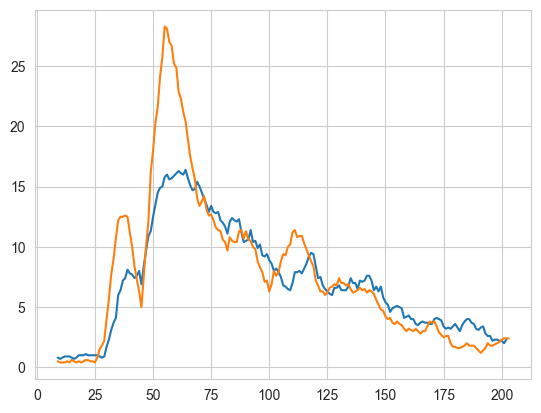

In [54]:
df0_bot.id_x.rolling(10).mean().plot()
df0_user.id_x.rolling(10).mean().plot()

In [69]:
df0_total.shape[0]

203

#### VAR

In [55]:
m_t0= VAR(df0_total[['diff_num_bot', 'diff_num_human', "media_bot", "media_human"]])
results = m_t0.fit(maxlags=10, ic='aic') 
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 20, Jun, 2024
Time:                     23:54:18
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                  -0.469131
Nobs:                     195.000    HQIC:                  -1.78764
Log likelihood:          -713.014    FPE:                  0.0691450
AIC:                     -2.68470    Det(Omega_mle):       0.0369964
--------------------------------------------------------------------
Results for equation diff_num_bot
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                     0.176853         0.252860            0.699           0.484
L1.diff_num_bot          -0.753889         0.079133           -9.527           0.000
L1.diff_num_human         0.123293   

In [498]:
lag_order = select_order(df0_total[['id_x_bot', 'id_x_human', "media_bot", "media_human"]], maxlags=10, deterministic="ci")

# Fit the VECM model
vecm_t0 = VECM(df0_total[['id_x_bot', 'id_x_human', "media_bot", "media_human"]], k_ar_diff=lag_order.aic,coint_rank=1)
vecm_results = vecm_t0.fit()
print(vecm_results.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation id_x_bot
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
L1.id_x_bot       -0.7118      0.076     -9.356      0.000      -0.861      -0.563
L1.id_x_human      0.0543      0.061      0.891      0.373      -0.065       0.174
L1.media_bot      10.9763      3.634      3.021      0.003       3.854      18.099
L1.media_human   -19.6288      8.324     -2.358      0.018     -35.943      -3.314
L2.id_x_bot       -0.5619      0.091     -6.145      0.000      -0.741      -0.383
L2.id_x_human      0.0733      0.065      1.121      0.262      -0.055       0.201
L2.media_bot       9.8262      3.435      2.861      0.004       3.094      16.558
L2.media_human   -16.7975      8.106     -2.072      0.038     -32.686      -0.909
L3.id_x_bot       -0.5328      0.095     -5.597      0.000      -0.719      -0.346

In [65]:
wald_test_coef(-0.15, 0.0546, 0.142,0.064, 1)

Wald Statistic: 1.725521846661171, P-value: 0.18898381094306915


##### 10MIN

In [508]:
df0_bot = get_time_series(0, "2019-11-23 17:00:00", "2019-11-24 10:00:00", 1, '60Min')
df0_user = get_time_series(0, "2019-11-23 17:00:00", "2019-11-24 10:00:00", 0, '60Min')
df0bot_diff = get_diff(df0_bot)
df0user_diff = get_diff(df0_user)

df0_total = df0bot_diff.merge(df0user_diff, on = "created_at_dt", how = "outer", suffixes=('_bot', '_human'))
df0_total['bot_pct'] = df0_total.id_x_bot/(df0_total.id_x_bot+df0_total.id_x_human)
df0_total.fillna(0,inplace = True)


In [509]:
lag_order = select_order(df0_total[['id_x_bot', 'id_x_human']], maxlags=2, deterministic="ci")

# Fit the VECM model
vecm_t0 = VECM(df0_total[['id_x_bot', 'id_x_human']], k_ar_diff=lag_order.aic)
vecm_results = vecm_t0.fit()
print(vecm_results.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation id_x_bot
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
L1.id_x_bot      -0.5832      0.591     -0.987      0.324      -1.742       0.575
L1.id_x_human     0.8428      0.561      1.501      0.133      -0.257       1.943
L2.id_x_bot       0.4285      0.379      1.130      0.259      -0.315       1.172
L2.id_x_human     0.2451      0.241      1.017      0.309      -0.227       0.717
Det. terms outside the coint. relation & lagged endog. parameters for equation id_x_human
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
L1.id_x_bot      -0.3891      1.254     -0.310      0.756      -2.848       2.069
L1.id_x_human     1.4903      1.191      1.251      0.211      -0.844       3.825
L2

#### Granger

In [ ]:
with open("granger_test_topics.txt", "a+") as f:
    f.write("\n\n")
    f.write("Topic 0:\n")
    f.write("bot - human\n")
    granger = grangercausalitytests([[i,j] for i,j in zip(list(df0_total.diff_num_bot), list(df0_total.diff_num_human))], 15)
    f.write(str(granger))
    f.write("human - bot\n")
    granger = grangercausalitytests([[i,j] for i,j in zip(list(df0_total.diff_num_human), list(df0_total.diff_num_bot))], 15)
    f.write(str(granger))

##### 10min

In [ ]:

lag_order = select_order(df5_total[['id_x_bot', 'id_x_human']], maxlags=2, deterministic="ci")

# Fit the VECM model
vecm_t0 = VECM(df0_total[['id_x_bot', 'id_x_human']], k_ar_diff=lag_order.aic)
vecm_results = vecm_t0.fit()
print(vecm_results.summary())

#### Topic 4

In [56]:
#Sentiment analysis - further calculations
df4_bot = get_time_series(4, "2019-11-23 17:00:00", "2019-11-24 02:00:00", 1, '5Min')
df4_user = get_time_series(4, "2019-11-23 17:00:00", "2019-11-24 02:00:00", 0, '5Min')

In [57]:
df4bot_diff = get_diff(df4_bot)
df4user_diff = get_diff(df4_user)
df4_total = df4bot_diff.merge(df4user_diff, on = "created_at_dt", how = "inner", suffixes=('_bot', '_human'))
df4_total['bot_pct'] = df4_total.id_x_bot/(df4_total.id_x_bot+df4_total.id_x_human)

In [58]:
df4_total = df4bot_diff.merge(df4user_diff, on = "created_at_dt", how = "inner", suffixes=('_bot', '_human'))
df4_total['bot_pct'] = df4_total.id_x_bot/(df4_total.id_x_bot+df4_total.id_x_human)

In [59]:
media_ctrl_t4 = get_media_ctrl("2019-11-23 17:00:00", "2019-11-24 02:00:00")
df4_total = df4_total.merge(media_ctrl_t4, left_on = "created_at_dt", right_on = "created_at_dt", how = "left")

In [60]:
df4_total.shape[0]

105

In [62]:
m_t4= VAR(df4_total[['diff_num_bot', 'diff_num_human', "media_bot"]])
results = m_t4.fit(maxlags=10, ic='aic') 
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 20, Jun, 2024
Time:                     23:55:07
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    15.5636
Nobs:                     97.0000    HQIC:                   14.3778
Log likelihood:          -996.194    FPE:                    813016.
AIC:                      13.5728    Det(Omega_mle):         408634.
--------------------------------------------------------------------
Results for equation diff_num_bot
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                    -0.149431         0.564360           -0.265           0.791
L1.diff_num_bot          -0.147782         0.118628           -1.246           0.213
L1.diff_num_human        -0.001551   

In [76]:
lag_order = select_order(df4_total[['id_x_bot', 'id_x_human',"media_bot"]], maxlags=20, deterministic="ci")

# Fit the VECM model
vecm_t4 = VECM(df4_total[['id_x_bot', 'id_x_human',"media_bot"]], k_ar_diff=lag_order.aic, coint_rank=1)
vecm_results = vecm_t4.fit()
print(vecm_results.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation id_x_bot
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
L1.id_x_bot        0.0089      0.119      0.075      0.940      -0.224       0.242
L1.id_x_human      0.0002      0.003      0.081      0.936      -0.005       0.006
L1.media_bot      -2.0951     13.222     -0.158      0.874     -28.010      23.820
L2.id_x_bot       -0.1652      0.121     -1.364      0.173      -0.403       0.072
L2.id_x_human      0.0008      0.003      0.290      0.772      -0.004       0.006
L2.media_bot      -8.2442     13.006     -0.634      0.526     -33.735      17.247
L3.id_x_bot       -0.4322      0.122     -3.552      0.000      -0.671      -0.194
L3.id_x_human      0.0006      0.003      0.233      0.815      -0.004       0.006
L3.media_bot     -10.9234     13.241     -0.825      0.409     -36.875      15.028

In [66]:
wald_test_coef(57.8928, 0.0004, 18.247,0.130)

Wald Statistic: 10.065564146098259, P-value: 0.0015106630206652705


In [ ]:
with open("granger_test_topics.txt", "a+") as f:
    f.write("\n\n")
    f.write("Topic 4:\n")
    f.write("bot - human\n")
    granger = grangercausalitytests([[i,j] for i,j in zip(list(df4_total.diff_num_bot), list(df4_total.diff_num_human))], 10)
    f.write(str(granger))
    f.write("human - bot\n")
    granger = grangercausalitytests([[i,j] for i,j in zip(list(df4_total.diff_num_human), list(df4_total.diff_num_bot))], 15)
    f.write(str(granger))

##### 10MIN

In [524]:
df4_bot = get_time_series(4, "2019-11-23 17:00:00", "2019-11-24 06:00:00", 1, '60Min')
df4_user = get_time_series(4, "2019-11-23 17:00:00", "2019-11-24 06:00:00", 0, '60Min')

In [525]:
df4bot_diff = get_diff(df4_bot)
df4user_diff = get_diff(df4_user)
df4_total = df4bot_diff.merge(df4user_diff, on = "created_at_dt", how = "inner", suffixes=('_bot', '_human'))
df4_total['bot_pct'] = df4_total.id_x_bot/(df4_total.id_x_bot+df4_total.id_x_human)

In [526]:
lag_order = select_order(df4_total[['id_x_bot', 'id_x_human']], maxlags=5, deterministic="ci")

# Fit the VECM model
vecm_t4 = VECM(df4_total[['id_x_bot', 'id_x_human']], k_ar_diff=lag_order.aic)
vecm_results = vecm_t4.fit()
print(vecm_results.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation id_x_bot
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
L1.id_x_bot       0.2375      0.013     18.832      0.000       0.213       0.262
L1.id_x_human     0.0010      0.000      3.949      0.000       0.001       0.002
Det. terms outside the coint. relation & lagged endog. parameters for equation id_x_human
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
L1.id_x_bot      51.0360      4.948     10.314      0.000      41.338      60.734
L1.id_x_human    -0.6268      0.102     -6.121      0.000      -0.828      -0.426
              Loading coefficients (alpha) for equation id_x_bot              
                 coef    std err          z      P>|z|      [0.025      0.975]
--------

##### Topic 4 - II 

In [ ]:
df4_bot2 = get_time_series(4, "2019-11-15 21:00:00", "2019-11-16 06:00:00", 1, '5Min')
df4_user2 = get_time_series(4, "2019-11-15 21:00:00", "2019-11-16 06:00:00", 0, '5Min')

In [ ]:
df4bot_diff2 = get_diff(df4_bot2)
df4user_diff2 = get_diff(df4_user2)

In [ ]:
df4_total2 = df4bot_diff2.merge(df4user_diff2, on = "created_at_dt", how = "inner", suffixes=('_bot', '_human'))
df4_total2['bot_pct'] = df4_total2.id_x_bot/(df4_total2.id_x_bot+df4_total2.id_x_human)

In [ ]:
df4_total2.id_x_bot.rolling(6).mean().plot()
df4_total2.id_x_human.rolling(6).mean().plot()

In [ ]:
df4_total2.bot_pct.rolling(12).mean().plot()

In [ ]:
df4_total2

In [ ]:
with open("granger_test_topics.txt", "a+") as f:
    f.write("\n\n")
    f.write("Topic 4 - incident II:\n")
    f.write("bot - human\n")
    granger = grangercausalitytests([[i,j] for i,j in zip(df4_total2.diff_num_bot, df4_total2.diff_num_human)],10)
    f.write(str(granger))
    f.write("human - bot\n")
    granger = grangercausalitytests([[i,j] for i,j in zip(df4_total2.diff_num_human, df4_total2.diff_num_bot)], 10)
    f.write(str(granger))

#### Topic 7

In [63]:
df7_bot = get_time_series(6, "2019-11-23 18:00:00", "2019-11-24 02:00:00", 1, '5Min')
df7_user = get_time_series(6, "2019-11-23 18:00:00", "2019-11-24 02:00:00", 0, '5Min')
df7bot_diff = get_diff(df7_bot)
df7user_diff = get_diff(df7_user)
df7_total = df7bot_diff.merge(df7user_diff, on = "created_at_dt", how = "inner", suffixes=('_bot', '_human'))
df7_total['bot_pct'] = df7_total.id_x_bot/(df7_total.id_x_bot+df7_total.id_x_human)

In [64]:
media_ctrl_t7 = get_media_ctrl( "2019-11-23 18:00:00", "2019-11-24 04:00:00")
df7_total = df7_total.merge(media_ctrl_t7, left_on = "created_at_dt", right_on = "created_at_dt", how = "left")

In [65]:
len(df7_total)

92

In [66]:
m_t7= VAR(df7_total[['diff_num_bot', 'diff_num_human', "media_bot"]])
results = m_t7.fit(maxlags=15, ic='aic') 
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 20, Jun, 2024
Time:                     23:57:01
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    6.46403
Nobs:                     78.0000    HQIC:                   4.12669
Log likelihood:          -303.121    FPE:                    19.6884
AIC:                      2.56640    Det(Omega_mle):         5.27399
--------------------------------------------------------------------
Results for equation diff_num_bot
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      0.097242         1.090175            0.089           0.929
L1.diff_num_bot           -0.374299         0.250568           -1.494           0.135
L1.diff_num_human          0.0852

In [68]:
wald_test_coef(0.5311, 0.178, 0.196,0.366)

Wald Statistic: 0.7233170700577821, P-value: 0.39505800086264664


In [63]:
lag_order = select_order(df7_total[['id_x_bot', 'id_x_human',"media_bot"]], maxlags=20, deterministic="ci")

# Fit the VECM model
vecm_t7 = VECM(df7_total[['id_x_bot', 'id_x_human',"media_bot"]], k_ar_diff=lag_order.aic,coint_rank=1)
vecm_results = vecm_t7.fit()
print(vecm_results.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation id_x_bot
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
L1.id_x_bot        0.3508      0.323      1.086      0.278      -0.283       0.984
L1.id_x_human     -0.7237      0.407     -1.777      0.076      -1.522       0.075
L1.media_bot     -63.3734     21.825     -2.904      0.004    -106.149     -20.598
L2.id_x_bot        0.3380      0.350      0.967      0.334      -0.347       1.023
L2.id_x_human     -0.2812      0.406     -0.693      0.488      -1.076       0.514
L2.media_bot     -76.6967     21.637     -3.545      0.000    -119.104     -34.290
L3.id_x_bot       -0.0875      0.310     -0.282      0.778      -0.695       0.520
L3.id_x_human     -0.1013      0.355     -0.286      0.775      -0.796       0.594
L3.media_bot     -55.6828     22.117     -2.518      0.012     -99.031     -12.334

In [ ]:
with open("granger_test_topics.txt", "a+") as f:
    f.write("\n\n")
    f.write("Topic 7:\n")
    f.write("bot - human\n")
    granger = grangercausalitytests([[i,j] for i,j in zip(df7_total.diff_num_bot, df7_total.diff_num_human)], 10)
    f.write(str(granger))
    f.write("human - bot\n")
    granger = grangercausalitytests([[i,j] for i,j in zip(df7_total.diff_num_human, df7_total.diff_num_bot)], 15)
    f.write(str(granger))

##### 10MIN

In [541]:
df7_bot = get_time_series(6, "2019-11-23 18:00:00", "2019-11-24 02:00:00", 1, '60Min')
df7_user = get_time_series(6, "2019-11-23 18:00:00", "2019-11-24 02:00:00", 0, '60Min')
df7bot_diff = get_diff(df7_bot)
df7user_diff = get_diff(df7_user)
df7_total = df7bot_diff.merge(df7user_diff, on = "created_at_dt", how = "inner", suffixes=('_bot', '_human'))
df7_total['bot_pct'] = df7_total.id_x_bot/(df7_total.id_x_bot+df7_total.id_x_human)

In [543]:
lag_order = select_order(df7_total[['id_x_bot', 'id_x_human']], maxlags=3, deterministic="ci")

# Fit the VECM model
vecm_t7 = VECM(df7_total[['id_x_bot', 'id_x_human']], k_ar_diff=lag_order.aic)
vecm_results = vecm_t7.fit()
print(vecm_results.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation id_x_bot
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
L1.id_x_bot      -0.0911      0.997     -0.091      0.927      -2.046       1.864
L1.id_x_human    -0.2334      1.588     -0.147      0.883      -3.347       2.880
Det. terms outside the coint. relation & lagged endog. parameters for equation id_x_human
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
L1.id_x_bot      -0.6765      1.099     -0.616      0.538      -2.830       1.477
L1.id_x_human     0.8090      1.750      0.462      0.644      -2.621       4.239
              Loading coefficients (alpha) for equation id_x_bot              
                 coef    std err          z      P>|z|      [0.025      0.975]
--------

/home/lindali/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/vector_ar/vecm.py:1577: RuntimeWarning: invalid value encountered in sqrt
  last_rows_1d = np.sqrt(np.diag(mat1.dot(mat2)))


### Sentiment

In [67]:
def get_diff_senti(df): 
    df_temp = df
    df_temp['diff_num'] = df_temp.abs_senti - df_temp.abs_senti.shift(1)
    df_temp = df_temp.dropna()
    return df_temp

##### Topic 6

In [37]:
df5_bot_senti = get_time_series_senti(5, "2019-11-29 16:00:00", "2019-11-30 04:00:00", 1, '5Min')
df5_user_senti = get_time_series_senti(5, "2019-11-29 16:00:00", "2019-11-30 04:00:00", 0, '5Min')
df5_total_senti = df5_bot_senti.merge(df5_user_senti, on = "created_at_dt", how = "outer", suffixes=('_bot', '_human'))
df5_total_senti.sentiment_bot.fillna(df5_total_senti.sentiment_bot.mean(), inplace = True)
df5_total_senti.sentiment_human.fillna(df5_total_senti.sentiment_human.mean(), inplace = True)
df5_total_senti['bot_diff'] = df5_total_senti.sentiment_bot - df5_total_senti.sentiment_bot.shift(1)
df5_total_senti['human_diff'] = df5_total_senti.sentiment_human - df5_total_senti.sentiment_human.shift(1)
df5_total_senti.dropna(inplace = True)

In [38]:
media_ctrl_t5 = get_media_ctrl( "2019-11-29 16:00:00", "2019-11-30 04:00:00")
df5_total_senti = df5_total_senti.merge(media_ctrl_t5, left_on = "created_at_dt", right_on = "created_at_dt", how = "left")

In [71]:
m_t5_senti= VAR(df5_total_senti[['bot_diff', 'human_diff', "media_bot", "media_human"]])
results = m_t5_senti.fit(maxlags=20, ic='aic') 
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 20, Jun, 2024
Time:                     23:59:46
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -5.49328
Nobs:                     123.000    HQIC:                  -9.89199
Log likelihood:           419.293    FPE:                7.15660e-06
AIC:                     -12.9010    Det(Omega_mle):     9.45815e-07
--------------------------------------------------------------------
Results for equation bot_diff
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                  -0.014310         0.044216           -0.324           0.746
L1.bot_diff            -0.764170         0.138000           -5.537           0.000
L1.human_diff           0.384113         0.170557

In [128]:
len(df5_total_senti)

143

In [49]:
wald_test_coef(-0.06, -0.6544, 0.19,0.23)

Wald Statistic: 3.969790561797754, P-value: 0.04632353376953613


In [43]:
lag_order = select_order(df5_total_senti[['sentiment_bot', 'sentiment_human', "media_bot", "media_human"]], maxlags=20, deterministic="ci")

# Fit the VECM model
vecm_t5 = VECM(df5_total_senti[['sentiment_bot', 'sentiment_human', "media_bot", "media_human"]], k_ar_diff=lag_order.aic,coint_rank=1)
vecm_results = vecm_t5.fit()
print(vecm_results.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation sentiment_bot
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
L1.sentiment_bot        0.5370      0.269      2.000      0.046       0.011       1.063
L1.sentiment_human     -0.9031      0.274     -3.294      0.001      -1.440      -0.366
L1.media_bot           -0.0526      0.052     -1.010      0.313      -0.155       0.050
L1.media_human         -0.9113      0.195     -4.680      0.000      -1.293      -0.530
L2.sentiment_bot        0.6571      0.255      2.581      0.010       0.158       1.156
L2.sentiment_human     -1.0089      0.270     -3.739      0.000      -1.538      -0.480
L2.media_bot           -0.1234      0.067     -1.853      0.064      -0.254       0.007
L2.media_human         -1.1792      0.233     -5.068      0.000      -1.635      -0.723
L3.sentiment_bot        0.5

In [ ]:
with open("granger_test_topics_senti.txt", "w") as f:
    f.write("Topic 5:\n")
    f.write("bot - human\n")
    granger = grangercausalitytests([[i,j] for i,j in zip(list(df5_total_senti.bot_diff), list(df5_total_senti.human_diff))], 12)
    f.write(str(granger))
    f.write("human - bot\n")
    granger = grangercausalitytests([[i,j] for i,j in zip(list(df5_total_senti.human_diff), list(df5_total_senti.bot_diff))], 12)
    f.write(str(granger))

##### 10min

In [604]:
df5_bot_senti = get_time_series_senti(5, "2019-11-29 16:00:00", "2019-11-30 04:00:00", 1, '60Min')
df5_user_senti = get_time_series_senti(5, "2019-11-29 16:00:00", "2019-11-30 04:00:00", 0, '60Min')
df5_total_senti = df5_bot_senti.merge(df5_user_senti, on = "created_at_dt", how = "outer", suffixes=('_bot', '_human'))
df5_total_senti.sentiment_bot.fillna(df5_total_senti.sentiment_bot.mean(), inplace = True)
df5_total_senti.sentiment_human.fillna(df5_total_senti.sentiment_human.mean(), inplace = True)
df5_total_senti['bot_diff'] = df5_total_senti.sentiment_bot - df5_total_senti.sentiment_bot.shift(1)
df5_total_senti['human_diff'] = df5_total_senti.sentiment_human - df5_total_senti.sentiment_human.shift(1)
df5_total_senti.dropna(inplace = True)

In [605]:
lag_order = select_order(df5_total_senti[['sentiment_bot', 'sentiment_human']], maxlags=5, deterministic="ci")

# Fit the VECM model
vecm_t5 = VECM(df5_total_senti[['sentiment_bot', 'sentiment_human']], k_ar_diff=lag_order.aic,coint_rank=1)
vecm_results = vecm_t5.fit()
print(vecm_results.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation sentiment_bot
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
L1.sentiment_bot       0.4366      0.182      2.393      0.017       0.079       0.794
L1.sentiment_human    -0.2272      0.193     -1.179      0.238      -0.605       0.151
Det. terms outside the coint. relation & lagged endog. parameters for equation sentiment_human
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
L1.sentiment_bot       0.8611      0.498      1.730      0.084      -0.115       1.837
L1.sentiment_human     0.3202      0.526      0.609      0.543      -0.710       1.351
           Loading coefficients (alpha) for equation sentiment_bot            
                 coef    std err     

/home/lindali/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/lindali/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/lindali/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/lindali/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/lindali/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and w

##### Topic 0

In [72]:
df0_bot_senti = get_time_series_senti(0, "2019-11-23 12:00:00", "2019-11-24 08:00:00", 1, '5Min')
df0_user_senti = get_time_series_senti(0, "2019-11-23 12:00:00", "2019-11-24 08:00:00", 0, '5Min')
df0_total_senti = df0_bot_senti.merge(df0_user_senti, on = "created_at_dt", how = "outer", suffixes=('_bot', '_human'))
df0_total_senti.sentiment_bot.fillna(df0_total_senti.sentiment_bot.mean(), inplace = True)
df0_total_senti.sentiment_human.fillna(df0_total_senti.sentiment_human.mean(), inplace = True)
df0_total_senti['bot_diff'] = df0_total_senti.sentiment_bot - df0_total_senti.sentiment_bot.shift(1)
df0_total_senti['human_diff'] = df0_total_senti.sentiment_human - df0_total_senti.sentiment_human.shift(1)
df0_total_senti.dropna(inplace = True)

In [73]:
media_ctrl_t0 = get_media_ctrl("2019-11-23 12:00:00", "2019-11-24 08:00:00")
df0_total_senti = df0_total_senti.merge(media_ctrl_t0, left_on = "created_at_dt", right_on = "created_at_dt", how = "left")

<Axes: >

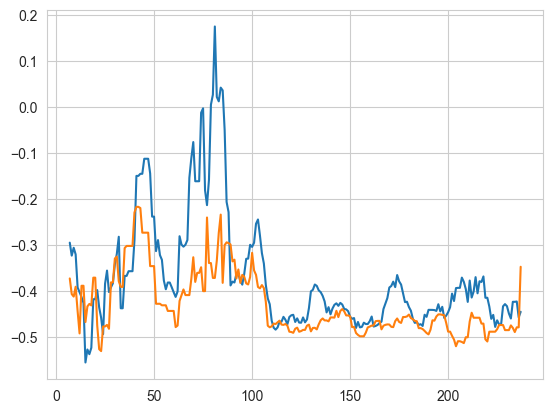

In [74]:
df0_total_senti.sentiment_bot.rolling(8).mean().plot()
df0_total_senti.sentiment_human.rolling(8).mean().plot()


In [75]:
m_t0_senti= VAR(df0_total_senti[['bot_diff', 'human_diff', "media_bot", "media_human"]])
results = m_t0_senti.fit(maxlags=10, ic='aic') 
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 21, Jun, 2024
Time:                     00:01:17
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -12.3963
Nobs:                     230.000    HQIC:                  -13.5735
Log likelihood:           479.060    FPE:                5.79301e-07
AIC:                     -14.3694    Det(Omega_mle):     3.38839e-07
--------------------------------------------------------------------
Results for equation bot_diff
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.005145         0.015772            0.326           0.744
L1.bot_diff           -0.835272         0.069444          -12.028           0.000
L1.human_diff          0.158764         0.094721     

In [138]:
lag_order = select_order(df0_total_senti[['sentiment_bot', 'sentiment_human', "media_bot", "media_human"]], maxlags=30, deterministic="ci")

# Fit the VECM model
vecm_t0 = VECM(df0_total_senti[['sentiment_bot', 'sentiment_human', "media_bot", "media_human"]], k_ar_diff=lag_order.aic,coint_rank=1)
vecm_results = vecm_t0.fit()
print(vecm_results.summary())


Det. terms outside the coint. relation & lagged endog. parameters for equation sentiment_bot
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
L1.sentiment_bot      -0.8033      0.066    -12.196      0.000      -0.932      -0.674
L1.sentiment_human     0.1152      0.086      1.339      0.180      -0.053       0.284
L1.media_bot           0.4728      0.182      2.597      0.009       0.116       0.829
L1.media_human        -1.2411      0.448     -2.771      0.006      -2.119      -0.363
L2.sentiment_bot      -0.6599      0.082     -8.063      0.000      -0.820      -0.499
L2.sentiment_human     0.3297      0.109      3.028      0.002       0.116       0.543
L2.media_bot           0.4351      0.166      2.624      0.009       0.110       0.760
L2.media_human        -0.9343      0.398     -2.347      0.019      -1.714      -0.154
L3.sentiment_bot      -0.5719      0.

In [139]:
len(df0_total_senti)

238

In [50]:
wald_test_coef(-0.02, 0.12, 0.053,0.082,1)

Wald Statistic: 2.056015944613448, P-value: 0.15160610308900957


In [ ]:
with open("granger_test_topics_senti.txt", "w") as f:
    f.write("Topic 0:\n")
    f.write("bot - human\n")
    granger = grangercausalitytests([[i,j] for i,j in zip(list(df0_total_senti.bot_diff), list(df0_total_senti.human_diff))], 12)
    f.write(str(granger))
    f.write("human - bot\n")
    granger = grangercausalitytests([[i,j] for i,j in zip(list(df0_total_senti.human_diff), list(df0_total_senti.bot_diff))], 12)
    f.write(str(granger))

##### 10min

In [561]:
df0_bot_senti = get_time_series_senti(0, "2019-11-23 12:00:00", "2019-11-24 08:00:00", 1, '60Min')
df0_user_senti = get_time_series_senti(0, "2019-11-23 12:00:00", "2019-11-24 08:00:00", 0, '60Min')
df0_total_senti = df0_bot_senti.merge(df0_user_senti, on = "created_at_dt", how = "outer", suffixes=('_bot', '_human'))
df0_total_senti.sentiment_bot.fillna(df0_total_senti.sentiment_bot.mean(), inplace = True)
df0_total_senti.sentiment_human.fillna(df0_total_senti.sentiment_human.mean(), inplace = True)
df0_total_senti['bot_diff'] = df0_total_senti.sentiment_bot - df0_total_senti.sentiment_bot.shift(1)
df0_total_senti['human_diff'] = df0_total_senti.sentiment_human - df0_total_senti.sentiment_human.shift(1)
df0_total_senti.dropna(inplace = True)

lag_order = select_order(df0_total_senti[['sentiment_bot', 'sentiment_human']], maxlags=2, deterministic="ci")

# Fit the VECM model
vecm_t0 = VECM(df0_total_senti[['sentiment_bot', 'sentiment_human']], k_ar_diff=lag_order.aic,coint_rank=1)
vecm_results = vecm_t0.fit()
print(vecm_results.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation sentiment_bot
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
L1.sentiment_bot       0.1076      0.151      0.712      0.476      -0.188       0.404
L1.sentiment_human    -0.6909      0.164     -4.208      0.000      -1.013      -0.369
L2.sentiment_bot       0.5280      0.173      3.060      0.002       0.190       0.866
L2.sentiment_human    -0.9215      0.166     -5.567      0.000      -1.246      -0.597
Det. terms outside the coint. relation & lagged endog. parameters for equation sentiment_human
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
L1.sentiment_bot      -0.3023      0.174     -1.732      0.083      -0.644       0.040
L1.sentiment_human    -0.4063

/home/lindali/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/lindali/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/lindali/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/lindali/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


##### Topic 4

In [61]:
df4_bot_senti = get_time_series_senti(4, "2019-11-23 15:00:00", "2019-11-24 02:00:00", 1, '5Min')
df4_user_senti = get_time_series_senti(4, "2019-11-23 15:00:00", "2019-11-24 02:00:00", 0, '5Min')

In [62]:
df4_total_senti = df4_bot_senti.merge(df4_user_senti, on = "created_at_dt", how = "outer", suffixes=('_bot', '_human'))
df4_total_senti.sentiment_bot.fillna(df4_total_senti.sentiment_bot.mean(), inplace = True)
df4_total_senti.sentiment_human.fillna(df4_total_senti.sentiment_human.mean(), inplace = True)

In [63]:
df4_total_senti['bot_diff'] = df4_total_senti.sentiment_bot - df4_total_senti.sentiment_bot.shift(1)
df4_total_senti['human_diff'] = df4_total_senti.sentiment_human - df4_total_senti.sentiment_human.shift(1)
df4_total_senti.dropna(inplace = True)

In [64]:
media_ctrl_t4 = get_media_ctrl("2019-11-23 15:00:00", "2019-11-24 02:00:00")
df4_total_senti = df4_total_senti.merge(media_ctrl_t4, left_on = "created_at_dt", right_on = "created_at_dt", how = "left")

<Axes: >

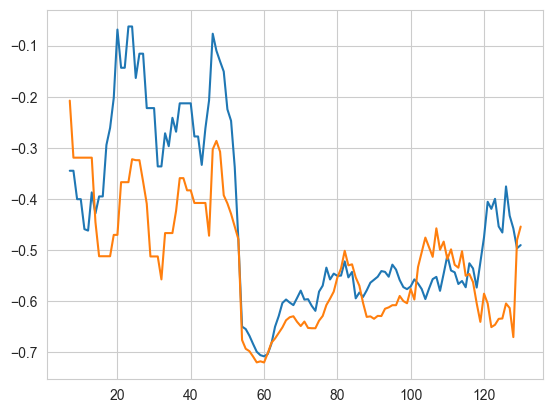

In [65]:
df4_total_senti.sentiment_bot.rolling(8).mean().plot()
df4_total_senti.sentiment_human.rolling(8).mean().plot()


In [66]:
df4_total_senti = df4_total_senti.fillna(0)

In [85]:
m_t4_senti= VAR(df4_total_senti[['bot_diff', 'human_diff', "media_bot"]])
results = m_t4_senti.fit(maxlags=25, ic='aic') 
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 21, Jun, 2024
Time:                     00:02:52
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -8.87424
Nobs:                     127.000    HQIC:                  -9.39280
Log likelihood:           117.360    FPE:                5.85580e-05
AIC:                     -9.74765    Det(Omega_mle):     4.37132e-05
--------------------------------------------------------------------
Results for equation bot_diff
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -0.004393         0.024629           -0.178           0.858
L1.bot_diff          -0.720563         0.095396           -7.553           0.000
L1.human_diff        -0.035380         0.092451          

In [147]:
len(df4_total_senti)

131

In [72]:
wald_test_coef( -0.041,0.337, 0.199,0.115)
     

Wald Statistic: 2.704804452353008, P-value: 0.10004634862713291


In [69]:
lag_order = select_order(df4_total_senti[['sentiment_bot', 'sentiment_human', "media_bot"]], maxlags=30, deterministic="ci")

# Fit the VECM model
vecm_t4 = VECM(df4_total_senti[['sentiment_bot', 'sentiment_human', "media_bot"]], k_ar_diff=lag_order.aic,coint_rank=1)
vecm_results = vecm_t4.fit()
print(vecm_results.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation sentiment_bot
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
L1.sentiment_bot        0.1732      0.105      1.644      0.100      -0.033       0.380
L1.sentiment_human     -0.3180      0.056     -5.699      0.000      -0.427      -0.209
L1.media_bot           -3.7630      0.505     -7.448      0.000      -4.753      -2.773
L2.sentiment_bot       -0.0674      0.070     -0.968      0.333      -0.204       0.069
L2.sentiment_human     -0.1386      0.080     -1.742      0.081      -0.294       0.017
L2.media_bot           -3.7967      0.479     -7.919      0.000      -4.736      -2.857
L3.sentiment_bot       -0.3299      0.076     -4.364      0.000      -0.478      -0.182
L3.sentiment_human     -0.2809      0.102     -2.743      0.006      -0.482      -0.080
L3.media_bot           -3.8

In [ ]:
with open("granger_test_topics_senti.txt", "w") as f:
    f.write("Topic 4:\n")
    f.write("bot - human\n")
    granger = grangercausalitytests([[i,j] for i,j in zip(list(df4_total_senti.bot_diff), list(df4_total_senti.human_diff))], 12)
    f.write(str(granger))
    f.write("human - bot\n")
    granger = grangercausalitytests([[i,j] for i,j in zip(list(df4_total_senti.human_diff), list(df4_total_senti.bot_diff))], 12)
    f.write(str(granger))

##### 10 min

In [574]:
df4_bot_senti = get_time_series_senti(4, "2019-11-23 15:00:00", "2019-11-24 02:00:00", 1, '60Min')
df4_user_senti = get_time_series_senti(4, "2019-11-23 15:00:00", "2019-11-24 02:00:00", 0, '60Min')

In [575]:
df4_total_senti = df4_bot_senti.merge(df4_user_senti, on = "created_at_dt", how = "outer", suffixes=('_bot', '_human'))
df4_total_senti.sentiment_bot.fillna(df4_total_senti.sentiment_bot.mean(), inplace = True)
df4_total_senti.sentiment_human.fillna(df4_total_senti.sentiment_human.mean(), inplace = True)
df4_total_senti['bot_diff'] = df4_total_senti.sentiment_bot - df4_total_senti.sentiment_bot.shift(1)
df4_total_senti['human_diff'] = df4_total_senti.sentiment_human - df4_total_senti.sentiment_human.shift(1)
df4_total_senti.dropna(inplace = True)

In [576]:
lag_order = select_order(df4_total_senti[['sentiment_bot', 'sentiment_human']], maxlags=2, deterministic="ci")

# Fit the VECM model
vecm_t4 = VECM(df4_total_senti[['sentiment_bot', 'sentiment_human']], k_ar_diff=lag_order.aic,coint_rank=1)
vecm_results = vecm_t4.fit()
print(vecm_results.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation sentiment_bot
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
L1.sentiment_bot       0.9237      2.626      0.352      0.725      -4.222       6.070
L1.sentiment_human    -0.4608      4.154     -0.111      0.912      -8.602       7.680
L2.sentiment_bot      -0.8739      3.592     -0.243      0.808      -7.913       6.165
L2.sentiment_human     0.8044      3.079      0.261      0.794      -5.230       6.839
Det. terms outside the coint. relation & lagged endog. parameters for equation sentiment_human
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
L1.sentiment_bot      -3.9546      2.312     -1.710      0.087      -8.487       0.578
L1.sentiment_human     7.3145

/home/lindali/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/lindali/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/lindali/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/lindali/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


##### Topic 7

In [86]:
df7_bot_senti = get_time_series_senti(6, "2019-11-23 18:00:00", "2019-11-24 02:00:00", 1, '5Min')
df7_user_senti = get_time_series_senti(6, "2019-11-23 18:00:00", "2019-11-24 02:00:00", 0, '5Min')

In [87]:
df7_bot_senti.columns

Index(['created_at_dt', 'sentiment'], dtype='object')

In [88]:
df7_total_senti = df7_bot_senti.merge(df7_user_senti, on = "created_at_dt", how = "outer", suffixes=('_bot', '_human'))
df7_total_senti.sentiment_bot.fillna(df7_total_senti.sentiment_bot.mean(), inplace = True)
df7_total_senti.sentiment_human.fillna(df7_total_senti.sentiment_human.mean(), inplace = True)

In [89]:
df7_total_senti['bot_diff'] = df7_total_senti.sentiment_bot - df7_total_senti.sentiment_bot.shift(1)
df7_total_senti['human_diff'] = df7_total_senti.sentiment_human - df7_total_senti.sentiment_human.shift(1)
df7_total_senti.dropna(inplace = True)

<Axes: >

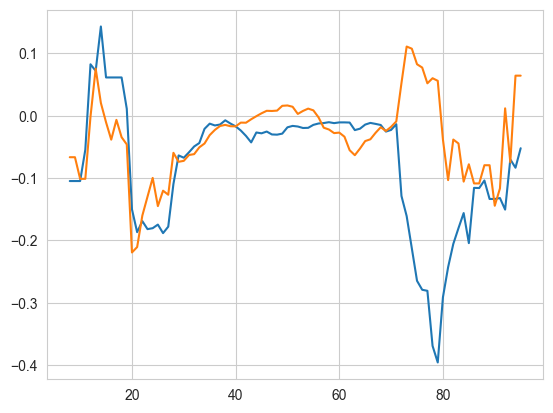

In [90]:
df7_total_senti.sentiment_bot.rolling(8).mean().plot()
df7_total_senti.sentiment_human.rolling(8).mean().plot()


In [91]:
media_ctrl_t7 = get_media_ctrl("2019-11-23 18:00:00", "2019-11-24 02:00:00")
df7_total_senti = df7_total_senti.merge(media_ctrl_t0, left_on = "created_at_dt", right_on = "created_at_dt", how = "left")

In [96]:
m_t7_senti= VAR(df4_total_senti[['bot_diff', 'human_diff']])
results = m_t7_senti.fit(maxlags=30, ic='aic') 
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 21, Jun, 2024
Time:                     00:05:38
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -4.78467
Nobs:                     127.000    HQIC:                  -5.02400
Log likelihood:          -12.9862    FPE:                 0.00558703
AIC:                     -5.18778    Det(Omega_mle):      0.00487204
--------------------------------------------------------------------
Results for equation bot_diff
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -0.002243         0.023882           -0.094           0.925
L1.bot_diff          -0.719840         0.093830           -7.672           0.000
L1.human_diff        -0.034942         0.090909          

In [156]:
len(df7_total_senti)

95

In [75]:
wald_test_coef(4.9460,3.6186,0.8333, 0.611)

Wald Statistic: 1.6502523545979328, P-value: 0.1989245877653849


In [155]:
lag_order = select_order(df7_total_senti[['sentiment_bot', 'sentiment_human']], maxlags=30, deterministic="ci")

# Fit the VECM model
vecm_t7 = VECM(df7_total_senti[['sentiment_bot', 'sentiment_human']], k_ar_diff=lag_order.aic,coint_rank=1)
vecm_results = vecm_t7.fit()
print(vecm_results.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation sentiment_bot
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
L1.sentiment_bot       -3.9329      0.502     -7.831      0.000      -4.917      -2.949
L1.sentiment_human      3.3375      0.533      6.259      0.000       2.292       4.383
L2.sentiment_bot       -3.9595      0.456     -8.693      0.000      -4.852      -3.067
L2.sentiment_human      2.5559      0.635      4.026      0.000       1.312       3.800
L3.sentiment_bot       -2.9605      0.480     -6.173      0.000      -3.901      -2.021
L3.sentiment_human      4.6042      0.536      8.590      0.000       3.554       5.655
L4.sentiment_bot       -3.3426      0.471     -7.096      0.000      -4.266      -2.419
L4.sentiment_human      1.9688      0.751      2.622      0.009       0.497       3.440
L5.sentiment_bot       -3.2

In [ ]:
with open("granger_test_topics_senti.txt", "w") as f:
    f.write("Topic 7:\n")
    f.write("bot - human\n")
    granger = grangercausalitytests([[i,j] for i,j in zip(list(df7_total_senti.bot_diff), list(df7_total_senti.human_diff))], 12)
    f.write(str(granger))
    f.write("human - bot\n")
    granger = grangercausalitytests([[i,j] for i,j in zip(list(df7_total_senti.human_diff), list(df7_total_senti.bot_diff))], 12)
    f.write(str(granger))

##### 10MINS

In [593]:
df7_bot_senti = get_time_series_senti(6, "2019-11-23 18:00:00", "2019-11-24 02:00:00", 1, '60Min')
df7_user_senti = get_time_series_senti(6, "2019-11-23 18:00:00", "2019-11-24 02:00:00", 0, '60Min')
df7_total_senti = df7_bot_senti.merge(df7_user_senti, on = "created_at_dt", how = "outer", suffixes=('_bot', '_human'))
df7_total_senti.sentiment_bot.fillna(df7_total_senti.sentiment_bot.mean(), inplace = True)
df7_total_senti.sentiment_human.fillna(df7_total_senti.sentiment_human.mean(), inplace = True)
df7_total_senti['bot_diff'] = df7_total_senti.sentiment_bot - df7_total_senti.sentiment_bot.shift(1)
df7_total_senti['human_diff'] = df7_total_senti.sentiment_human - df7_total_senti.sentiment_human.shift(1)
df7_total_senti.dropna(inplace = True)

In [596]:
lag_order = select_order(df7_total_senti[['sentiment_bot', 'sentiment_human']], maxlags=3, deterministic="ci")

# Fit the VECM model
vecm_t7 = VECM(df7_total_senti[['sentiment_bot', 'sentiment_human']], k_ar_diff=lag_order.aic,coint_rank=1)
vecm_results = vecm_t7.fit()
print(vecm_results.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation sentiment_bot
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
L1.sentiment_bot       1.8331      3.041      0.603      0.547      -4.127       7.793
L1.sentiment_human    -0.9610      2.738     -0.351      0.726      -6.327       4.405
Det. terms outside the coint. relation & lagged endog. parameters for equation sentiment_human
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
L1.sentiment_bot       0.0057      0.354      0.016      0.987      -0.688       0.700
L1.sentiment_human     0.5955      0.319      1.868      0.062      -0.029       1.220
           Loading coefficients (alpha) for equation sentiment_bot            
                 coef    std err     

/home/lindali/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/lindali/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/lindali/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/lindali/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/lindali/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and w

### Full analysis period

#### Granger

In [64]:
for i in [0,4,5,7]:
    print(f"Topic {i}")
    bot_all = get_time_series_senti(i, date_start = None, date_end = None, is_bot=1, freq = 'H')
    human_all = get_time_series_senti(i, date_start = None, date_end = None,is_bot=0, freq = 'H')
    #bot_diff = get_diff_senti(bot_all)
    #human_diff = get_diff_senti(human_all)
    
    total = bot_all.merge(human_all, on = "created_at_dt", how = "outer", suffixes=('_bot', '_human'))
    total.dropna(inplace = True)
    print(len(total))
   # print(total)
    
    lag_order = select_order(total[['sentiment_bot', 'sentiment_human']], maxlags=8, deterministic="ci")

    # Fit the VECM model
    vecm = VECM(total[['sentiment_bot', 'sentiment_human']], k_ar_diff=lag_order.aic,coint_rank=1)
    vecm_results = vecm.fit()
    print(vecm_results.summary())


Topic 0
652
Det. terms outside the coint. relation & lagged endog. parameters for equation sentiment_bot
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
L1.sentiment_bot      -0.4192      0.045     -9.218      0.000      -0.508      -0.330
L1.sentiment_human    -0.0709      0.041     -1.748      0.080      -0.150       0.009
L2.sentiment_bot      -0.1642      0.039     -4.231      0.000      -0.240      -0.088
L2.sentiment_human     0.0023      0.030      0.075      0.940      -0.057       0.062
Det. terms outside the coint. relation & lagged endog. parameters for equation sentiment_human
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
L1.sentiment_bot      -0.2710      0.062     -4.363      0.000      -0.393      -0.149
L1.sentiment_huma

/home/lindali/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/lindali/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/lindali/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/lindali/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/lindali/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and w

650
Det. terms outside the coint. relation & lagged endog. parameters for equation sentiment_bot
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
L1.sentiment_bot      -0.5374      0.049    -11.042      0.000      -0.633      -0.442
L1.sentiment_human    -0.1209      0.044     -2.718      0.007      -0.208      -0.034
L2.sentiment_bot      -0.3484      0.048     -7.305      0.000      -0.442      -0.255
L2.sentiment_human    -0.1073      0.039     -2.786      0.005      -0.183      -0.032
L3.sentiment_bot      -0.2062      0.039     -5.258      0.000      -0.283      -0.129
L3.sentiment_human    -0.0217      0.029     -0.741      0.459      -0.079       0.036
Det. terms outside the coint. relation & lagged endog. parameters for equation sentiment_human
                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------

/home/lindali/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/lindali/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/lindali/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/lindali/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/lindali/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and w

655
Det. terms outside the coint. relation & lagged endog. parameters for equation sentiment_bot
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
L1.sentiment_bot      -0.3595      0.054     -6.623      0.000      -0.466      -0.253
L1.sentiment_human    -0.2638      0.048     -5.477      0.000      -0.358      -0.169
L2.sentiment_bot      -0.2412      0.052     -4.681      0.000      -0.342      -0.140
L2.sentiment_human    -0.1509      0.044     -3.446      0.001      -0.237      -0.065
L3.sentiment_bot      -0.2183      0.046     -4.702      0.000      -0.309      -0.127
L3.sentiment_human    -0.1309      0.038     -3.461      0.001      -0.205      -0.057
L4.sentiment_bot      -0.0604      0.038     -1.573      0.116      -0.136       0.015
L4.sentiment_human    -0.0743      0.029     -2.582      0.010      -0.131      -0.018
Det. terms outside the coint. rel

/home/lindali/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/lindali/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/lindali/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/lindali/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/lindali/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and w

647
Det. terms outside the coint. relation & lagged endog. parameters for equation sentiment_bot
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
L1.sentiment_bot      -0.4004      0.046     -8.639      0.000      -0.491      -0.310
L1.sentiment_human    -0.1660      0.041     -4.064      0.000      -0.246      -0.086
L2.sentiment_bot      -0.2128      0.039     -5.389      0.000      -0.290      -0.135
L2.sentiment_human    -0.0653      0.030     -2.187      0.029      -0.124      -0.007
Det. terms outside the coint. relation & lagged endog. parameters for equation sentiment_human
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
L1.sentiment_bot      -0.3723      0.064     -5.856      0.000      -0.497      -0.248
L1.sentiment_human    -0.

/home/lindali/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/lindali/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/lindali/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/lindali/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/lindali/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and w

In [69]:
## F-test
# topic 0
normalised_F_test_coef(-0.158,-0.2333, 0.0546,0.055, 203, 335)

NameError: name 'coef_A_to_B_1' is not defined

#### vis

In [ ]:
topics = pd.read_csv("topic_time_burstiness.csv")
topics['created_at_dt'] = pd.to_datetime(topics.created_at_dt, infer_datetime_format=True)

In [ ]:
topics

In [ ]:
sns.set_style("whitegrid")
fig, axs = plt.subplots(7,1, figsize=(10,16), sharex = True, sharey = True)
#tweet = tweet.reset_index()
for i, topic in enumerate(range(1,8)):
    temp_df = topics[topics.topic == topic]
    #tweet_all = get_time_series(topic-1, date_start = None, date_end = None, is_bot=None, freq = 'H')
    
    axs[i].plot(temp_df.created_at_dt, temp_df.abs_senti.rolling(24).mean(), color = "#c85200", label = "Number of tweets")
    axs[i].set_title(topic_titles[i])
    ax2 = axs[i].twinx()
    ax2.plot(temp_df.created_at_dt, temp_df.burstiness.rolling(12).mean(), color = "gray", alpha = 0.5, label = 'Burstiness')
    ax2.set_ylim(-1.5,10)
    ax2.grid(False)


axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
axs[0].legend()
ax2.legend()


axs[1].set_xlim(datetime.datetime(2019,11,15,16,0,0), datetime.datetime(2019,12,13,0,0,0))
#axs[6].set_ylim(0,1)
fig.text(0.01, 0.5, 'Absolute Sentiment', va='center', rotation='vertical', fontsize = 14)
fig.text(0.98, 0.5, 'Burstiness Score', va='center', rotation='vertical', fontsize = 14)
fig.text(0.5, 0.01, 'Date', ha='center',fontsize = 14)
plt.tight_layout()
#plt.savefig("./NLP/senti_all_topics_wbursty.png")

In [ ]:
sns.set_style("whitegrid")
fig, axs = plt.subplots(2,1, figsize=(10,4), sharex = True, sharey = True)
for i, topic in enumerate([6,3]):
    temp_df = topics[topics.topic == topic]
    tweet_all = get_time_series(topic-1, date_start = None, date_end = None, is_bot=None, freq = 'H')
    axs[i].fill_between(tweet_all.created_at_dt, tweet_all.id_x.rolling(12).mean(), color = "#c85200", label = "Number of tweets", alpha = 0.4)
    axs[i].plot(tweet_all.created_at_dt, tweet_all.id_x.rolling(12).mean(), color = "#c85200")
    
    ax2 = axs[i].twinx()
    ax2.plot(temp_df.created_at_dt, temp_df.burstiness.rolling(12).mean(), color = "#59a14f",label = 'Burstiness')
    if i == 1:
        ax2.set_ylim(-1.5,6.5)
    ax2.grid(False)


axs[0].set_title("Topic 6 - Anti XR protest sentiment (bursty)", size = 12)
axs[1].set_title("Topic 3 - Climate change denial messages (non-bursty)", size = 12)
    
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
axs[0].legend()
ax2.legend()


axs[1].set_xlim(datetime.datetime(2019,11,15,16,0,0), datetime.datetime(2019,12,13,0,0,0))
#axs[6].set_ylim(0,250)
fig.text(0.01, 0.5, 'Tweets posted', va='center', rotation='vertical', fontsize = 14)
fig.text(0.98, 0.5, 'Burstiness Score', va='center', rotation='vertical', fontsize = 14)
fig.text(0.5, 0.01, 'Date', ha='center',fontsize = 14)
plt.tight_layout()
plt.savefig("./botometer_based_svg/topic_freq_total_wbursty_filled.png")

In [ ]:
fig, axs = plt.subplots(7,1, figsize=(10,18), sharex = True)
for i in range(7):
    bot_all = get_time_series(i, date_start = None, date_end = None, is_bot=1, freq = 'H')
    human_all = get_time_series(i, date_start = None, date_end = None,is_bot=0, freq = 'H')
    axs[i].plot(bot_all.created_at_dt, list(bot_all.id_x.rolling(12).mean()), color = "#D62728", label = "Bot tweets")
    axs[i].plot(human_all.created_at_dt, list(human_all.id_x.rolling(12).mean()), color = "#1F77B4", label = "Human tweets")
    axs[i].set_title(topic_titles[i], size = 12)
axs[6].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
axs[0].legend()
axs[6].set_xlim(datetime.datetime(2019,11,15,16,0,0), datetime.datetime(2019,12,13,0,0,0))
#axs[6].set_ylim(0,250)
fig.text(0.08, 0.5, 'Tweets posted', va='center', rotation='vertical', fontsize = 16)
fig.text(0.5, 0.08, 'Date', ha='center',fontsize = 16)
plt.savefig("./botometer_based_svg/topic_freq_total.png")

## wald tests

In [5]:

from scipy.stats import chi2

In [1]:
def wald_test_coef(coef_A_to_B,se_A_to_B,coef_B_to_A, se_B_to_A, df=1):
    # Calculate the difference in coefficients
    #coef_diff = coef_A_to_B - coef_B_to_A
    wald_statistic = ((coef_A_to_B - coef_B_to_A) ** 2) / (se_A_to_B ** 2 + se_B_to_A ** 2)


    # Degrees of freedom (assuming large sample, you can approximate with large number)
    p_value = 1 - chi2.cdf(wald_statistic, df)
    # One-sided p-value for the F-test (t-test)

    print(f"Wald Statistic: {wald_statistic}, P-value: {p_value}")
    return

In [2]:
from scipy import stats

def normalised_wald_test_coef_coef(coef_A_to_B,coef_B_to_A, se_A_to_B,se_B_to_A, len1, len2):
    
    # Normalize the coefficients
    normalized_coef_A_to_B = coef_A_to_B / se_A_to_B
    normalized_coef_B_to_A = coef_B_to_A / se_B_to_A

    coef_diff = coef_A_to_B - coef_B_to_A

    se_diff = (se_A_to_B**2 + se_B_to_A**2)**0.5

    t_stat = coef_diff / se_diff
    

    # Degrees of freedom (assuming large sample, you can approximate with large number)
    normalized_coef_diff = normalized_coef_A_to_B - normalized_coef_B_to_A

    # Estimate the standard error for the normalized coefficients
    se_normalized_coef1 = se_A_to_B / np.sqrt(len1)
    se_normalized_coef2 = se_B_to_A/ np.sqrt(len2)

    # Standard error of the difference
    se_diff_normalized = np.sqrt(se_normalized_coef1**2 + se_normalized_coef2**2)

    # t-statistic
    t_stat_normalized = normalized_coef_diff / se_diff_normalized

    # Degrees of freedom (assuming large sample, you can approximate with large number)
    df = len1 + len2 -2 

    # One-sided p-value for the F-test (t-test)
    p_value_normalized = stats.t.sf(t_stat_normalized, df)

    print(f"T-statistic (normalized): {t_stat_normalized}, P-value (normalized): {p_value_normalized}")

    return

### Amounts

In [19]:
# topic 0
wald_test_coef(0.06,0.064,0.05,0.33) #human


Wald Statistic: 0.0008849870791886428, P-value: 0.9762674462696973


In [20]:
wald_test_coef(-0.13,0.089, 0.139,0.069)

Wald Statistic: 5.705803501025076, P-value: 0.016908913598461806


In [14]:
# topic 4

wald_test_coef(0.0004 ,0.002, -0.0324,0.039)

Wald Statistic: 0.7054688524590162, P-value: 0.40095215951560137


In [15]:
wald_test_coef( 57.8928 ,18.247, 5.4092 ,0.645)

Wald Statistic: 8.26269985520011, P-value: 0.004046790033487735


In [16]:
# topic 5
wald_test_coef(-0.4581,0.060, 0.3391,0.045)

Wald Statistic: 112.98272711111113, P-value: 0.0


In [17]:
wald_test_coef(4.2767,0.683, 0.3391,0.045)

Wald Statistic: 33.09334141562471, P-value: 8.783901717102083e-09


In [18]:
#7
wald_test_coef( 0.5311,0.196, -0.1883, 0.037)
 

Wald Statistic: 13.008328767123286, P-value: 0.00031010858381674833


In [36]:
wald_test_coef( 0.178, 0.366, 0.26,0.064)
 

Wald Statistic: 0.048706284588415985, P-value: 0.8253299221423016


### Sentiment

In [25]:
#0
wald_test_coef( 0.1225,0.082,-0.0709,0.041)
 

Wald Statistic: 4.450155859607377, P-value: 0.03489806154536934


In [26]:


wald_test_coef( -0.0209 ,0.053,-0.2710, 0.062)

Wald Statistic: 9.401775139035026, P-value: 0.0021677546111805723


In [28]:
 #4
wald_test_coef( 0.3356 ,0.115, -0.1209, 0.044)
   

Wald Statistic: 13.745283952245895, P-value: 0.0002093457622222017


In [29]:
 wald_test_coef(-0.0408,0.199,-0.2951,0.067)


Wald Statistic: 1.46673826264459, P-value: 0.22586102830525312


In [30]:
#5
wald_test_coef(0.6274,0.189,-0.2638,0.048)

Wald Statistic: 20.887243655489808, P-value: 4.871278353912878e-06


In [31]:
wald_test_coef(-0.0709 , 0.196 ,-0.3275, 0.075)

Wald Statistic: 1.4950514293499237, P-value: 0.2214343531150188


In [32]:
#7
wald_test_coef(3.6186,0.611 ,-0.1660, 0.041)

Wald Statistic: 38.19498872006016, P-value: 6.401661423183214e-10


In [33]:
wald_test_coef(4.9460,0.8333,-0.3723, 0.064)

Wald Statistic: 40.493810667829905, P-value: 1.972398910865536e-10


## SI stuff, granger causality on different CAPs

In [ ]:
def get_time_series_freq(topic_num, date_start, date_end, is_bot, freq, threshold):
    temp_df = tweet.copy()
    temp_df['is_bot_temp_binary'] = [1 if i > threshold else 0 for i in temp_df.is_bot_botometer_prob]
    temp_df.index = temp_df.created_at_dt
    if date_start is not None and date_end is not None:
        temp_df = temp_df[(temp_df.index >= date_start) & (temp_df.index <= date_end)]
    temp_df = temp_df[temp_df.topic == topic_num]
    
    df = temp_df[temp_df.is_bot_temp_binary == is_bot].groupby(pd.Grouper(freq = freq)).aggregate('count')[['id_x']].reset_index()
    return df

def get_time_series_senti(topic_num, date_start, date_end, is_bot, freq, threshold):
    
    temp_df = tweet.copy()
    temp_df['is_bot_temp_binary'] = [1 if i > threshold else 0 for i in temp_df.is_bot_botometer_prob]
    temp_df.index = temp_df.created_at_dt
    if date_start is not None and date_end is not None:
        temp_df = temp_df[(temp_df.index >= date_start) & (temp_df.index <= date_end)]
    temp_df = temp_df[temp_df.topic == topic_num]
    df = temp_df[temp_df.is_bot_temp_binary == is_bot].groupby(pd.Grouper(freq = freq))['sentiment'].mean().reset_index()
    return df


def get_diff(df, col):
    df_temp = df
    df_temp['diff_num'] = df_temp[col] - df_temp[col].shift(1)
    df_temp = df_temp.dropna()
    return df_temp

In [ ]:
def generate_granger_causality(threshold, topic, date_start, date_end, metric = "freq"):
    if metric == "freq":
        df_bot = get_time_series_freq(topic, date_start,date_end, 1, '5Min', threshold)
        df_user = get_time_series_freq(topic, date_start,date_end, 0, '5Min', threshold)
        diff_col = 'id_x'
    else:
        df_bot = get_time_series_senti(topic, date_start,date_end, 1, '5Min', threshold)
        df_user = get_time_series_senti(topic, date_start,date_end, 0, '5Min', threshold)
        diff_col = 'sentiment'
        
    dfbot_diff = get_diff(df_bot, diff_col)
    dfuser_diff = get_diff(df_user, diff_col)
    df_total = dfbot_diff.merge(dfuser_diff, on = "created_at_dt", how = "inner", suffixes=('_bot', '_human'))
    
    human_bot = grangercausalitytests([[i,j] for i,j in zip(list(df_total.diff_num_bot), list(df_total.diff_num_human))], 7)
    bot_human = grangercausalitytests([[i,j] for i,j in zip(list(df_total.diff_num_human), list(df_total.diff_num_bot))], 7)
    
    return str(human_bot),str(bot_human)
    
    

In [ ]:
cascades = {
           0:  ["2019-11-23 17:00:00", "2019-11-24 12:00:00"],
           #4: ["2019-11-23 17:00:00", "2019-11-24 06:00:00"],
           #5: ["2019-11-29 18:00:00", "2019-11-30 04:00:00"],
           #6:["2019-11-23 18:00:00", "2019-11-24 02:00:00"]
}
thresholds = [0.5, 0.55, 0.6,0.65, 0.7, 0.75]

with open("./granger/granger_test_topics_all_CAP.txt", "w") as f:
    for c in cascades.keys():
        for t in thresholds:
            print(str(c)+ "\n" + str(t)+ "\n")
            print("FREQUENCY\n")
            
            freq_human, freq_bot = generate_granger_causality(t, c, cascades[c][0], cascades[c][1])
            print("SENTIMENT")
            senti_human, senti_bot = generate_granger_causality(t, c, cascades[c][0], cascades[c][1], "senti")
            
            
            
            f.write(str(c)+ "\n")
            f.write(str(t)+ "\n")
            f.write("FREQUENCY\n")
            f.write("human - bot\n")
            f.write(freq_human)
            f.write("bot - human\n")
            f.write(freq_bot)
            f.write("SENTIMENT")
            f.write("human - bot\n")
            f.write(senti_human)
            f.write("bot - human\n")
            f.write(senti_bot)
            


## Preprocessing FOR REFERENCE

#### Cleaning data

In [5]:
pwd

'/home/lindali/Dropbox/bot and agenda-setting/GITHUB_PUBLIC_VERSION/analysis'

In [6]:
current_dir = os.getcwd()
relative_path_to_data = os.path.join('..', 'data')
absolute_path_to_data = os.path.join(current_dir, relative_path_to_data)

In [7]:
absolute_path_to_data 

'/home/lindali/Dropbox/bot and agenda-setting/GITHUB_PUBLIC_VERSION/analysis/../data'

In [8]:
#user_path = "./cascade_analysis_data/xr_users_classified_0422_wprob.csv"
user_path_botometer = "./cascade_analysis_data/xr_users_classified_0704_four_methods_wprob.csv" # Please use this one, I commented out the other. This is the one with botometer prob
tweet_path = "./cascade_analysis_data/tweet_table_xr_2019.csv"
tweet_topic_modelled = "./cascade_analysis_data/text_classified.csv"
media_ctrl_path = "./cascade_analysis_data/RT_media_aggregation.csv"

In [9]:
#Preprocessing
users = pd.read_csv(os.path.join(absolute_path_to_data, user_path_botometer))
tweet = pd.read_csv(os.path.join(absolute_path_to_data, tweet_path))
tweet_classified = pd.read_csv(os.path.join(absolute_path_to_data, tweet_topic_modelled), lineterminator='\n')
media_ctrl = pd.read_csv(os.path.join(absolute_path_to_data, media_ctrl_path))

/tmp/ipykernel_287697/3982594376.py:3: DtypeWarning: Columns (46) have mixed types. Specify dtype option on import or set low_memory=False.
  tweet = pd.read_csv(os.path.join(absolute_path_to_data, tweet_path))


In [10]:
threshold = 0.65
users['is_bot_botometer_binary'] = [1 if i>threshold else 0 if i<=0.5 else None for i in users.is_bot_botometer_prob] 

In [11]:
tweet['created_at_dt'] = pd.to_datetime(tweet.created_at, infer_datetime_format=True)
#users['created_at_dt'] = pd.to_datetime(users.created_at, infer_datetime_format=True)
#Matching users classification results with tweets
tweet = tweet.merge(users[['is_bot_botometer_prob','is_bot_botometer_binary','id']], how = 'left', left_on = 'author_id', right_on = 'id', copy = False)
tweet = tweet.merge(tweet_classified, how = 'left', left_on = "text", right_on = "text", copy = False)

/tmp/ipykernel_287697/3392314550.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  tweet['created_at_dt'] = pd.to_datetime(tweet.created_at, infer_datetime_format=True)


In [12]:
tweet.dropna(subset = ['topic'], inplace = True)

In [13]:

users_with_tweet = pd.DataFrame({'author_id':list(set(list(tweet.author_id)))})
users_new = users.merge(users_with_tweet[['author_id']], how = 'inner', left_on = 'id', right_on = 'author_id', copy = False)
#To keep only users with tweets here

In [14]:
users[users['is_bot_botometer_binary'] == 1].shape[0]

53324

In [15]:
users[users['is_bot_botometer_binary'] == 0].shape[0]

55319

In [16]:
display(69303/(69303+67232))

0.5075841359358406

In [17]:
#Use Existing tool for pilot & building pipeline
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [18]:

sid_obj = SentimentIntensityAnalyzer()

In [19]:
def get_sentiment(text):
    sentiment_dict = sid_obj.polarity_scores(text)
    return sentiment_dict['compound']

In [20]:
tweet['sentiment'] = [get_sentiment(i) for i in tweet.text]

In [21]:
tweet.sentiment.mean()

-0.20147987218872698

In [22]:
tweet['abs_senti'] = [abs(i) for i in tweet.sentiment]

In [23]:
necessary_columns = [
    'id_x',  # tweet ID
    'referenced_tweets_0_id',  # referenced tweet for retweets
    'in_reply_to_user_id',  # reply tweet
    'author_id',  # tweet author
    'created_at_dt',  # timestamp of the tweet
    'is_bot_botometer_prob',  # bot probability for bot/human classification
    'is_bot_botometer_binary',  # binary classification for bot/human
    'topic',  # topic of the tweet
    'sentiment',  # sentiment score
    'abs_senti'  # absolute sentiment score
]

In [25]:
tweet = tweet[necessary_columns]

In [26]:
tweet

,id_x,referenced_tweets_0_id,in_reply_to_user_id,author_id,created_at_dt,is_bot_botometer_prob,is_bot_botometer_binary,topic,sentiment,abs_senti
1,1202301644697985024,1.202286e+18,NaN,1163160406086553603,2019-12-04 19:00:24+00:00,0.705338,1.0,1.0,0.2023,0.2023
3,1202301589823770624,1.201959e+18,1.961714e+09,25138405,2019-12-04 19:00:11+00:00,0.676362,1.0,6.0,0.0498,0.0498
5,1202301588624355328,1.202233e+18,NaN,1009038760783302656,2019-12-04 19:00:11+00:00,0.528866,NaN,5.0,0.2960,0.2960
6,1202301557729087488,1.202179e+18,NaN,23227936,2019-12-04 19:00:03+00:00,0.790759,1.0,0.0,0.0000,0.0000
7,1202301431593783303,1.200853e+18,NaN,3311765200,2019-12-04 18:59:33+00:00,0.747084,1.0,6.0,-0.0516,0.0516
...,...,...,...,...,...,...,...,...,...,...
215460,1202302005261287432,1.202273e+18,2.153358e+08,4288454451,2019-12-04 19:01:50+00:00,0.447947,0.0,3.0,0.0000,0.0000
215463,1202301762046177282,1.202286e+18,NaN,740995314266558464,2019-12-04 19:00:52+00:00,0.800880,1.0,1.0,0.2023,0.2023
215464,1202301699639140352,NaN,NaN,1370479314,2019-12-04 19:00:37+00:00,0.226318,0.0,5.0,0.0000,0.0000
215465,1202301677551935489,1.202233e+18,NaN,314575336,2019-12-04 19:00:32+00:00,0.278726,0.0,5.0,0.2960,0.2960


### anynomoization

In [27]:
import pandas as pd

def factorize_column_pairs(df):
    # Combine id_x and referenced_tweets_0_id for factorization
    combined_tweet_ids = pd.concat([df['id_x'], df['referenced_tweets_0_id']]).unique()
    tweet_id_map = {id_val: idx for idx, id_val in enumerate(combined_tweet_ids)}
    
    # Apply the mapping to both columns
    df['id_x'] = df['id_x'].map(tweet_id_map)
    df['referenced_tweets_0_id'] = df['referenced_tweets_0_id'].map(tweet_id_map)

    # Combine in_reply_to_user_id and author_id for factorization
    combined_user_ids = pd.concat([df['in_reply_to_user_id'], df['author_id']]).unique()
    user_id_map = {id_val: idx for idx, id_val in enumerate(combined_user_ids)}
    
    # Apply the mapping to both columns
    df['in_reply_to_user_id'] = df['in_reply_to_user_id'].map(user_id_map)
    df['author_id'] = df['author_id'].map(user_id_map)
    
    return df

# Apply the function
tweet = factorize_column_pairs(tweet)

# Save the modified DataFrame



In [30]:
pwd

'/home/lindali/Dropbox/bot and agenda-setting/GITHUB_PUBLIC_VERSION/analysis'

In [31]:
tweet.to_csv('../data/cascade_analysis_data/anonymized_tweet_for_info_flow.csv', index=False)